This python file is for running time evolution with LA field 

In [1]:
import numpy as np
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas

np.set_printoptions(precision=6)
# initialize variables
N = 12
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
B = 0.1     # !!! NEED TO BE CHANGED
J_matrix = np.zeros((N, N), dtype='float64')
J_value = 1
J_matrix_alpha = 1   # !!! NEED TO BE CHANGED
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [2]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis 

for n in range(Q):  # n is an unused index
    
    # couple_num_list would be my result for each state we loop
    
    if len(loop_state_list)!=0: # loop for couple number for one state
                
        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)
        
        for m in range(Q): # loop for spin and spatial for all states inside the couple number list
            
            if m==0:
                
                couple_num_list_old =couple_num_list
                
                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection 
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # spatial reflection 
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)
                    
                    # remove the repeated element 
                    couple_num_list = np.unique(couple_num_list)
            else:
                
                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first 
                    couple_num_list_old =couple_num_list
                    
                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection 
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)
                        
                        
                        # spatial reflection 
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)
                        
                        # remove the repeated element 
                        couple_num_list = np.unique(couple_num_list)
                        
        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())
        
        # remove the ones already found 
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

            


In [3]:
# now we want to decide the sign for each term 

for i in range(len(couple_state_matrix)):
#for i in range(1,2):
    
    state_num = couple_state_matrix[i]
    #print(state_num)
    
    # get spin & spatial reflection array without sign
    spin_num_array = np.zeros(len(state_num),dtype=int)
    spatial_num_array = np.zeros(len(state_num),dtype=int)
    
    for j in range(len(state_num)):
        
        array = D2B(state_num[j])

        # spin reflection 
        spin_relfection_array = spin_reflection(array)
        spin_number = B2D(spin_relfection_array)
        spin_num_array[j] = spin_number
        #print(spin_num_array)
        
        # spatial reflection 
        spatial_relfection_array = spatial_reflection(array)
        spatial_number = B2D(spatial_relfection_array)
        spatial_num_array[j] = spatial_number
        #print(spatial_num_array)

    
    # loop all possbie sign        
        
    state_number_length = len(state_num) 
    for j in range( pow(2,state_number_length) ):
        
        sign_array = D2B_with_digit(j,state_number_length)
        
        # convert it into 1 or -1
        
        for k in range(len(sign_array)):
            # the choice for sign here does not matter since we only the right + and -, what number it's is fine 
            if sign_array[k] == 1:
                sign_array[k] = -1
            else:
                sign_array[k] = 1
                
        # combine signs on the reflection array sort is for comparison only 
        
        temp_spin_num = spin_num_array * sign_array
        temp_spin_num = np.sort(temp_spin_num)
        #print(temp_spin_num)
        
        temp_spatial_num = spatial_num_array * sign_array
        temp_spatial_num =np.sort(temp_spatial_num)
        
        # combine the sign for the orginal state number array
        
        #temp_spin_b4_num = state_num * sign_array * -1   # this one is for odd parity 
        temp_spin_b4_num = state_num * sign_array  
        temp_spin_b4_num = np.sort(temp_spin_b4_num)

        #temp_spatial_b4_num = state_num * sign_array * -1 # this one is for odd parity
        temp_spatial_b4_num = state_num * sign_array
        temp_spatial_b4_num = np.sort(temp_spatial_b4_num)
        
        
        # check the parity here 
        if np.array_equal(temp_spin_num,temp_spin_b4_num):

            if np.array_equal(temp_spatial_num,temp_spatial_b4_num):
                if sign_array[0]==1: # just so to pick out the positive ones since all negatives would also work
                    sign_matrix.append(sign_array.tolist())
                    
                    

In [4]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

In [5]:
# loop each basis to fill in the diagonal elements for HA matrix 

for i in range(couple_dimen):
    
    state_array = np.array( couple_state_matrix[i] )
    
    # loop each element inside the array 
    normalization = len(state_array)
    
    # energy total for all the product states inside one basis
    
    e_tot = 0
    for j in range(len(state_array)):
        
        state = D2B(state_array[j])
        
        # loop over N sites to change the state vector to either 1 or -1
        
        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs
        
        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

In [6]:
# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):
    
    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))
    
    for j in state_array:
        vector_form_basis_matrix[i][j] = 1
        
    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization
    
    

In [7]:
# loop each basis to fill in HB matrix 

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):
        
        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0
        
     
    # generate the vector form for the state after operrator acting on it
    
    vector_final_state = np.zeros(Q)
    
    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1
        
    # put back normalization factor 
    vector_final_state = vector_final_state/normalization
    
    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):
        
        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [8]:
# get true ground state 
w, v = LA.eigh(HA_matrix + B* HB_matrix)
inx = np.argsort(w)
true_gs_vec = v[:, inx[0]]

In [9]:
# get  ground state with numerically infinite large B field
w, v = LA.eigh(HB_matrix)
inx = np.argsort(w)
temp_vec = v[:, inx[0]] # the index here could be zero or one, depending on the parity
# but if the wrong index will always give roughly zero fidelity 

In [10]:
# read B field file 
time_and_B_data = pandas.read_csv(f"./B_profile_N={N}_a={J_matrix_alpha}_B_start={20}_B_0={0.1}.csv")
time_list = time_and_B_data['time'].to_numpy()
B_list = time_and_B_data['B'].to_numpy()

In [11]:
# # diabatic gamma
diabatic_gamma = 10  
time_list = diabatic_gamma * time_list
target_time_length = np.max(time_list)
print('ramp time is',target_time_length)

ramp time is 29.355691745570777


In [12]:
# turn B into a function of t, so that we can just change B later but not t

# fixed number of layers
# dt_size = target_time_length/15
# number_of_layers = int(target_time_length/dt_size)

# fixed dt size
dt_size = 0.01
number_of_layers = int(target_time_length/dt_size)

# diabatic gamma
diabatic_gamma = number_of_layers*dt_size/np.max(time_list)


time_list = diabatic_gamma * time_list
target_time_length = np.max(time_list)
print('ramp time is',target_time_length,'gamma is ',diabatic_gamma)


bi = Akima1DInterpolator(time_list, B_list)
t_data_smooth = np.linspace(min(time_list), max(time_list),number_of_layers)# Number of steps to take for time evolution 
B_data_smooth = bi(t_data_smooth)
dt = t_data_smooth[1]-t_data_smooth[0]
print('dt = ',dt)
print( 'number of layers is', number_of_layers)

ramp time is 29.35 gamma is  0.9998061110049763
dt =  0.010003407747280858
number of layers is 2935


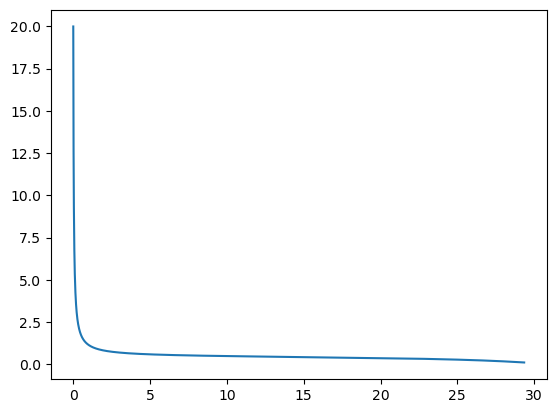

In [13]:
plt.plot(t_data_smooth,B_data_smooth)

In [14]:
# get fidelity for t= 0s
fidelity_t_0 = pow(np.dot(true_gs_vec,temp_vec),2)

In [15]:
# linear case
# B_data_smooth = np.linspace(20,0.1,2935)
# dt_size=0.01

In [16]:
import json
# Load and print a sample of the saved data
def read_saved_data(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data
gs_data = read_saved_data("gs_data.json")

In [17]:
# run the case with just LA to see the base
# time evolution
final_fidelity_list =[]
# final_fidelity_list.append(fidelity_t_0)
step = len(B_data_smooth)
instanously_fidelity_list = []
instanously_and_true_gs_fidelity_list=[]
# product state
p = temp_vec  # p stands for product
inst_B_list=[]    
 # loop each time step
    
for i in range(step): # start with 1 because the 0th element already put in at the lines above
    
    H_matrix = HA_matrix + B_data_smooth[i]*HB_matrix
    
    # instanous gs 

    # w, v = LA.eigh(H_matrix)
    # inx = np.argsort(w)
    # instanous_gs = v[:, inx[0]]
   
    ### 
    exp_imgH_matrix = expm( -1*1j*dt_size*H_matrix )
    new_p = np.dot(exp_imgH_matrix,p)

    ### get the highest inst fidelity
    max_fidelity = 0
    best_B_value = None
    for B_value, gs_vector in gs_data.items():
        dp = np.dot(gs_vector,new_p) # dp is dot product
        #print(dp)
        dp_cc = np.conjugate(dp)     # the complex conjucate of the dot product 
        fidelity = (dp*dp_cc).real
        if fidelity > max_fidelity:
            max_fidelity = fidelity
            best_B_value = B_value   

    instanously_fidelity_list.append(max_fidelity)
    inst_B_list.append(best_B_value)

    
    #calculate fieldlity 
    dp = np.dot(true_gs_vec,new_p) # dp is dot product
    #print(dp)
    dp_cc = np.conjugate(dp)     # the complex conjucate of the dot product 
    fidelity = (dp*dp_cc).real
    final_fidelity_list.append(fidelity)

    
    # update state
    p = new_p

In [18]:
# plt.plot(instanously_fidelity_list)
# plt.ylim(0.9,1)

In [19]:
inst_B_list = np.array(inst_B_list, dtype=float)

In [20]:
final_fidelity_list_array=np.array(final_fidelity_list)
instanously_fidelity_list_array=np.array(instanously_fidelity_list)
# instanously_and_true_gs_fidelity_list_array=np.array(instanously_and_true_gs_fidelity_list)

In [22]:
# # Save the array to a file
# np.save('fig_1_la_la_gs_prob.npy', final_fidelity_list)
# np.save('fig_1_la_inst_gs_prob.npy', instanously_fidelity_list)
# np.save('fig_1_la_b_list.npy', inst_B_list)


# np.save('fig_1_linear_gs_prob.npy', final_fidelity_list)
# np.save('fig_1_linear_inst_gs_prob.npy', instanously_fidelity_list)
# np.save('fig_1_linear_b_list.npy', inst_B_list)


# np.save('D2_1_la_instanously_and_true_gs.npy', instanously_and_true_gs_fidelity_list_array)

# load data for LA data
final_fidelity_list_array = np.load('fig_1_la_gs_prob.npy')
instanously_fidelity_list_array =  np.load('fig_1_la_inst_gs_prob.npy')

final_fidelity_list_array_1 = np.load('long_la_gs_prob.npy')
instanously_fidelity_list_array_1 =  np.load('long_la_inst_gs_prob.npy')

# load data for linear data
# B_data_smooth = np.linspace(20,0.1,2935)
# dt_size=0.01
# final_fidelity_list_array = np.load('fig_1_linear_gs_prob.npy')
# instanously_fidelity_list_array =  np.load('fig_1_linear_inst_gs_prob.npy')
# instanously_and_true_gs_fidelity_list_array = np.load('fig_1_linear_instanously_and_true_gs.npy')

In [23]:
# read B field file 
time_and_B_data = pandas.read_csv(f"./B_profile_N={N}_a={J_matrix_alpha}_B_start={50}_B_0={0.1}.csv")
time_list = time_and_B_data['time'].to_numpy()
B_list = time_and_B_data['B'].to_numpy()
# # diabatic gamma
diabatic_gamma = 100  
time_list = diabatic_gamma * time_list
target_time_length = np.max(time_list)
print('ramp time is',target_time_length)
# turn B into a function of t, so that we can just change B later but not t

# fixed number of layers
# dt_size = target_time_length/15
# number_of_layers = int(target_time_length/dt_size)

# fixed dt size
dt_size = 0.001
number_of_layers = int(target_time_length/dt_size)

# diabatic gamma
diabatic_gamma = number_of_layers*dt_size/np.max(time_list)


time_list = diabatic_gamma * time_list
target_time_length = np.max(time_list)
print('ramp time is',target_time_length,'gamma is ',diabatic_gamma)


bi = Akima1DInterpolator(time_list, B_list)
t_data_smooth = np.linspace(min(time_list), max(time_list),number_of_layers)# Number of steps to take for time evolution 
B_data_smooth_1 = bi(t_data_smooth)
dt = t_data_smooth[1]-t_data_smooth[0]
print('dt = ',dt)
print( 'number of layers is', number_of_layers)

ramp time is 293.7506321366524
ramp time is 293.75 gamma is  0.9999978480500694
dt =  0.0010000033168017658
number of layers is 293750


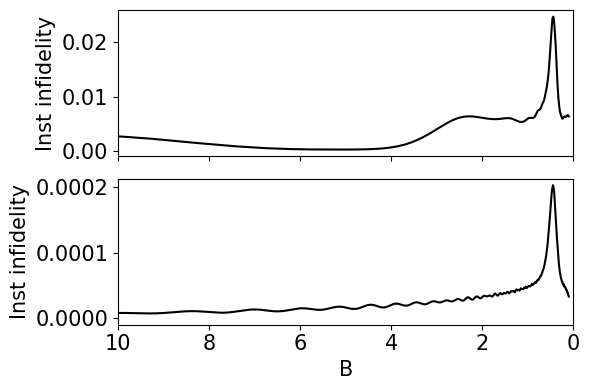

In [24]:

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)  # 2 rows, 1 column

# Subplot 0
ax1.plot(B_data_smooth, 1-instanously_fidelity_list_array, label="Final Fidelity", color="black")
ax1.set_ylabel("Inst infidelity", fontsize=15)  # Label size for y-axis
# ax1.set_yticks(np.arange(0, 0.08, 0.02))  # Ensures it includes 1.0
ax1.tick_params(axis='y', labelsize=15)  # Tick size for y-axis
ax1.tick_params(axis='x', labelsize=15)  # Tick size for shared x-axis

# Subplot 1
ax2.plot(B_data_smooth_1, 1-instanously_fidelity_list_array_1, label="Instantaneous Fidelity", color="black")
#ax2.plot(B_data_smooth, instanously_fidelity_list_array, label="Instantaneous Fidelity", color="black")
ax2.set_xlabel("B", fontsize=15)  # Label size for x-axis
ax2.set_ylabel("Inst infidelity", fontsize=15)  # Label size for y-axis
ax2.set_xlim(10, 0)
# ax2.set_yticks(np.linspace(0, 0.1,5))  # Ensures it includes 1.0
ax2.tick_params(axis='y', labelsize=15)  # Tick size for y-axis
ax2.tick_params(axis='x', labelsize=15)  # Tick size for x-axis

# Adjust layout
plt.tight_layout()
plt.savefig('LA_fidelity_verus_B.pdf')
# Show plot
plt.show()